# Network model 

This notebook can be used to play with the network model with arbitrary values of the parameters

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import oaconvolve
from scipy.stats import gennorm

from network_model import (
    MicroMagnet,
    generate_averaging_filter,
)

In [2]:
mu_B = 2

In [4]:
def get_NIS(Ny, Nx, border, B_ax, M_fun, g, h_s, h_c, xi, seed=None):
    """
    Calculate NIS conductance by taking ratio of the Sc domain over normal domains.
    """
    conductance = np.zeros_like(B_ax)

    averaging_filter = generate_averaging_filter(xi)
    mm = MicroMagnet(shape=(Ny + 2 * border, Nx + 2 * border), seed=seed)

    for i, B in enumerate(B_ax):
        mm.set_M(M_fun(B))

        h_eff = (
            oaconvolve(h_s * mm.config, averaging_filter, mode="same")
            + g / 2 * mu_B * B
        )
        domains_sc = 1 * (abs(h_eff) < h_c)

        if border > 0:
            h_eff = h_eff[border:-border, border:-border]
            domains_sc = domains_sc[border:-border, border:-border]

        conductance[i] = 1 - np.sum(domains_sc) / (Ny * Nx)

    return conductance

In [5]:
def plot_NIS(h_c, h_s, xi, g):
    Nx = 150  # Number of domains
    Ny = 150
    border = 50

    h_cc = h_c * np.ones((Nx + 2 * border, Ny + 2 * border))
    h_ss = h_s * np.ones((Nx + 2 * border, Ny + 2 * border))

    # Disorder in h_s
    disorder_beta = 2
    disorder_scale = 0
    rvs = gennorm.rvs(
        loc=1,
        scale=disorder_scale,
        beta=disorder_beta,
        size=(Nx + 2 * border) * (Ny + 2 * border),
    )
    rvs = rvs.reshape(Nx + 2 * border, Ny + 2 * border)

    def M_fun(x, o, s1, s2, C1, C2):
        t1 = (x - o) / s1
        t2 = (x - o) / s2
        return (C1 * np.tanh(t1) + C2 * np.tanh(t2)) / (C1 + C2)

    C1 = 1
    C2 = 0
    s1 = 1
    s2 = 1
    Hc = 0.5

    B_ax = np.linspace(-6, 6, 120)

    def M_fun_up(B):
        return M_fun(B, +Hc, s1, s2, C1, C2)

    def M_fun_down(B):
        return M_fun(B, -Hc, s1, s2, C1, C2)

    nis_th_up = get_NIS(Nx, Ny, border, B_ax, M_fun_up, g, h_ss, h_cc, xi)
    nis_th_down = get_NIS(Nx, Ny, border, B_ax, M_fun_down, g, h_ss, h_cc, xi)

    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

    if g != 0:
        B_star = (h_c - h_s) / g
    else:
        B_star = -1000

    ax1.plot(B_ax, nis_th_up, "-C0", label=r"$x_{N, th}^\rightarrow$")
    ax1.plot(B_ax, nis_th_down, "-C1", label=r"$x_{N, th}^\leftarrow$")
    ax1.legend(ncol=2)
    ax1.set_ylabel(r"$x_N$")
    ax1.set_title(
        rf"$\xi/d={{{xi:4.3f}}}, h_s = {{{h_s:4.3f}}}, h_c = {{{h_c:4.3f}}}, g={{{g:4.3f}}}$"
    )
    if B_star > 0:
        ax1.vlines([-B_star, B_star], 0, 1, "k", linestyles="--", linewidth=1)

    ax2.plot(B_ax, M_fun_up(B_ax) * h_s, "-C0", label=r"$h_s M$")
    ax2.plot(B_ax, M_fun_down(B_ax) * h_s, "-C1", label=r"$h_s M$")
    ax2.plot(B_ax, M_fun_up(B_ax) * h_s + g * B_ax, "--C0", label=r"$h_s M + g B$")
    ax2.plot(B_ax, M_fun_down(B_ax) * h_s + g * B_ax, "--C1", label=r"$h_s M+ g B$")
    ax2.hlines(
        [-h_c, h_c], -6, 6, "k", linestyle="--", linewidth=0.25, label=r"$\pm h_C$"
    )
    ax2.legend(ncol=2)

    # ax3 = ax2.twinx()
    # ax3.vlines(B_ax[[NS_idx_up, SN_idx_up]], -1, 1, "k", linestyles="--", linewidth=1)
    # ax3.vlines(B_ax[[NS_idx_down, SN_idx_down]], -1, 1, "k", linestyles="--", linewidth=1)
    # ax3.set_ylim(np.array([*ax2.get_ylim()])/h_s)

    # # plt.xlim(-220, 240)  # A4 limits
    # plt.xlim(-45, 75)     #12 limits

## No Zeeman

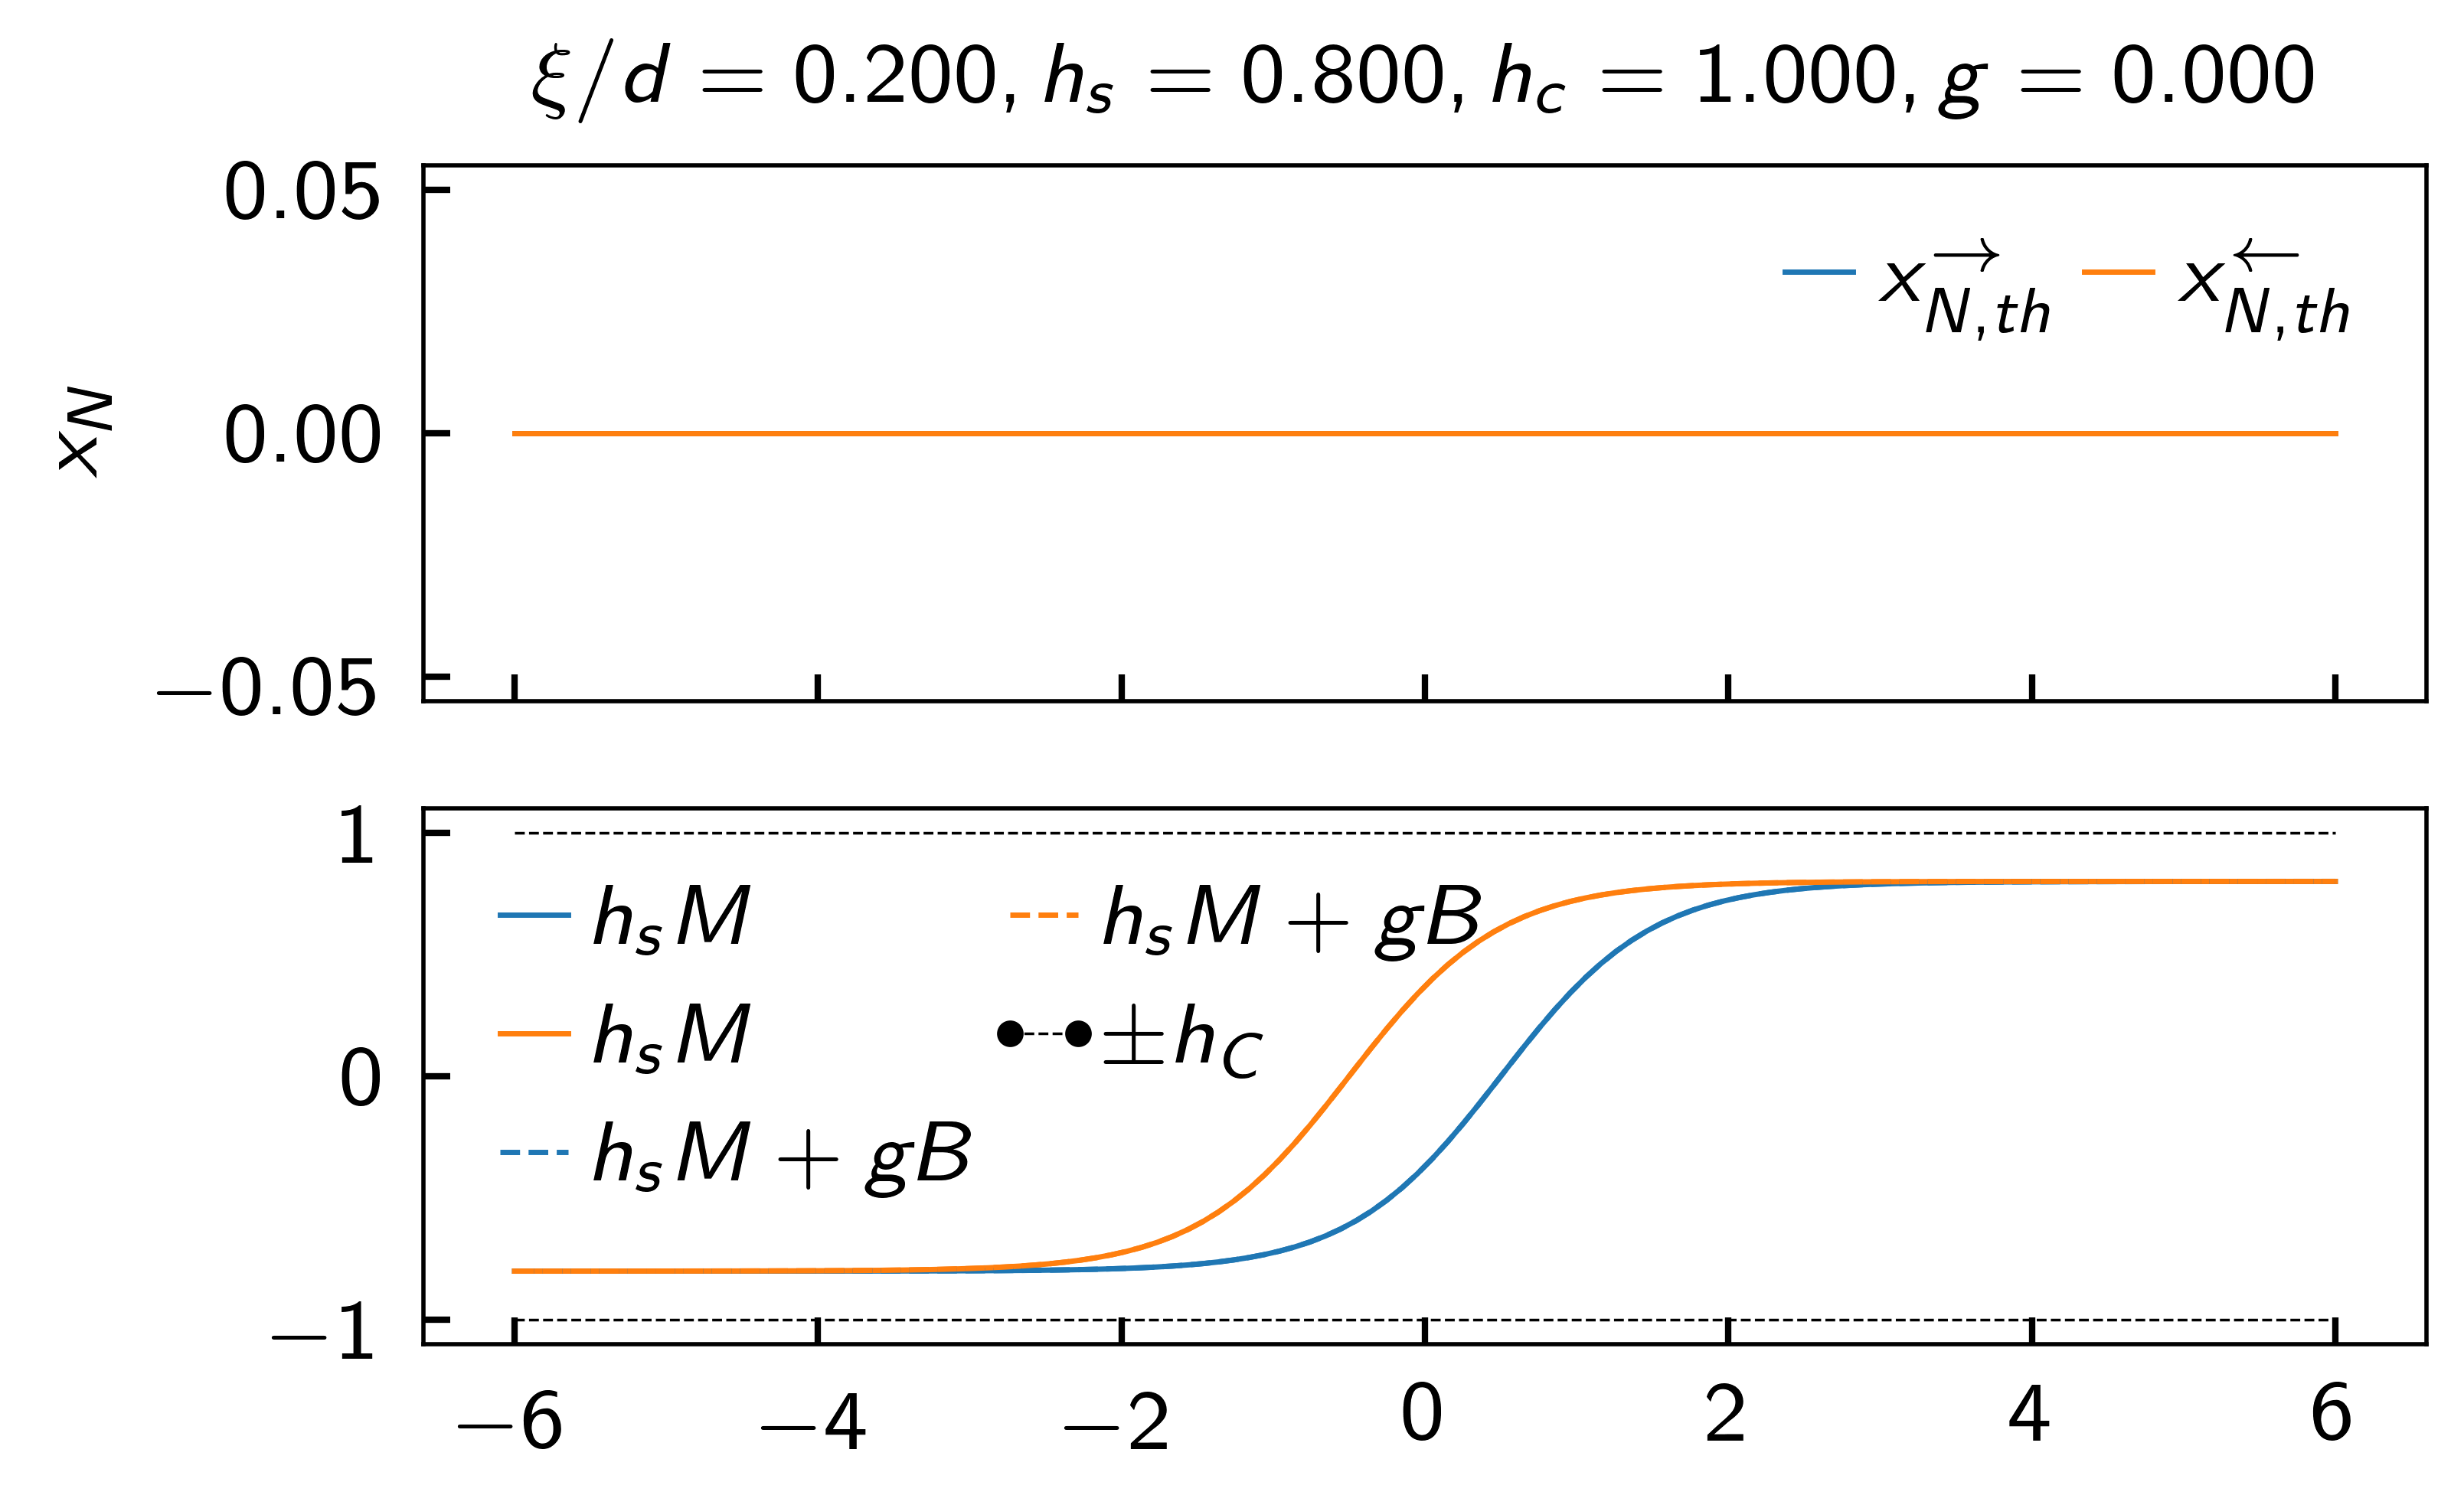

In [6]:
plot_NIS(h_c=1, h_s=0.8, xi=0.2, g=0.0)

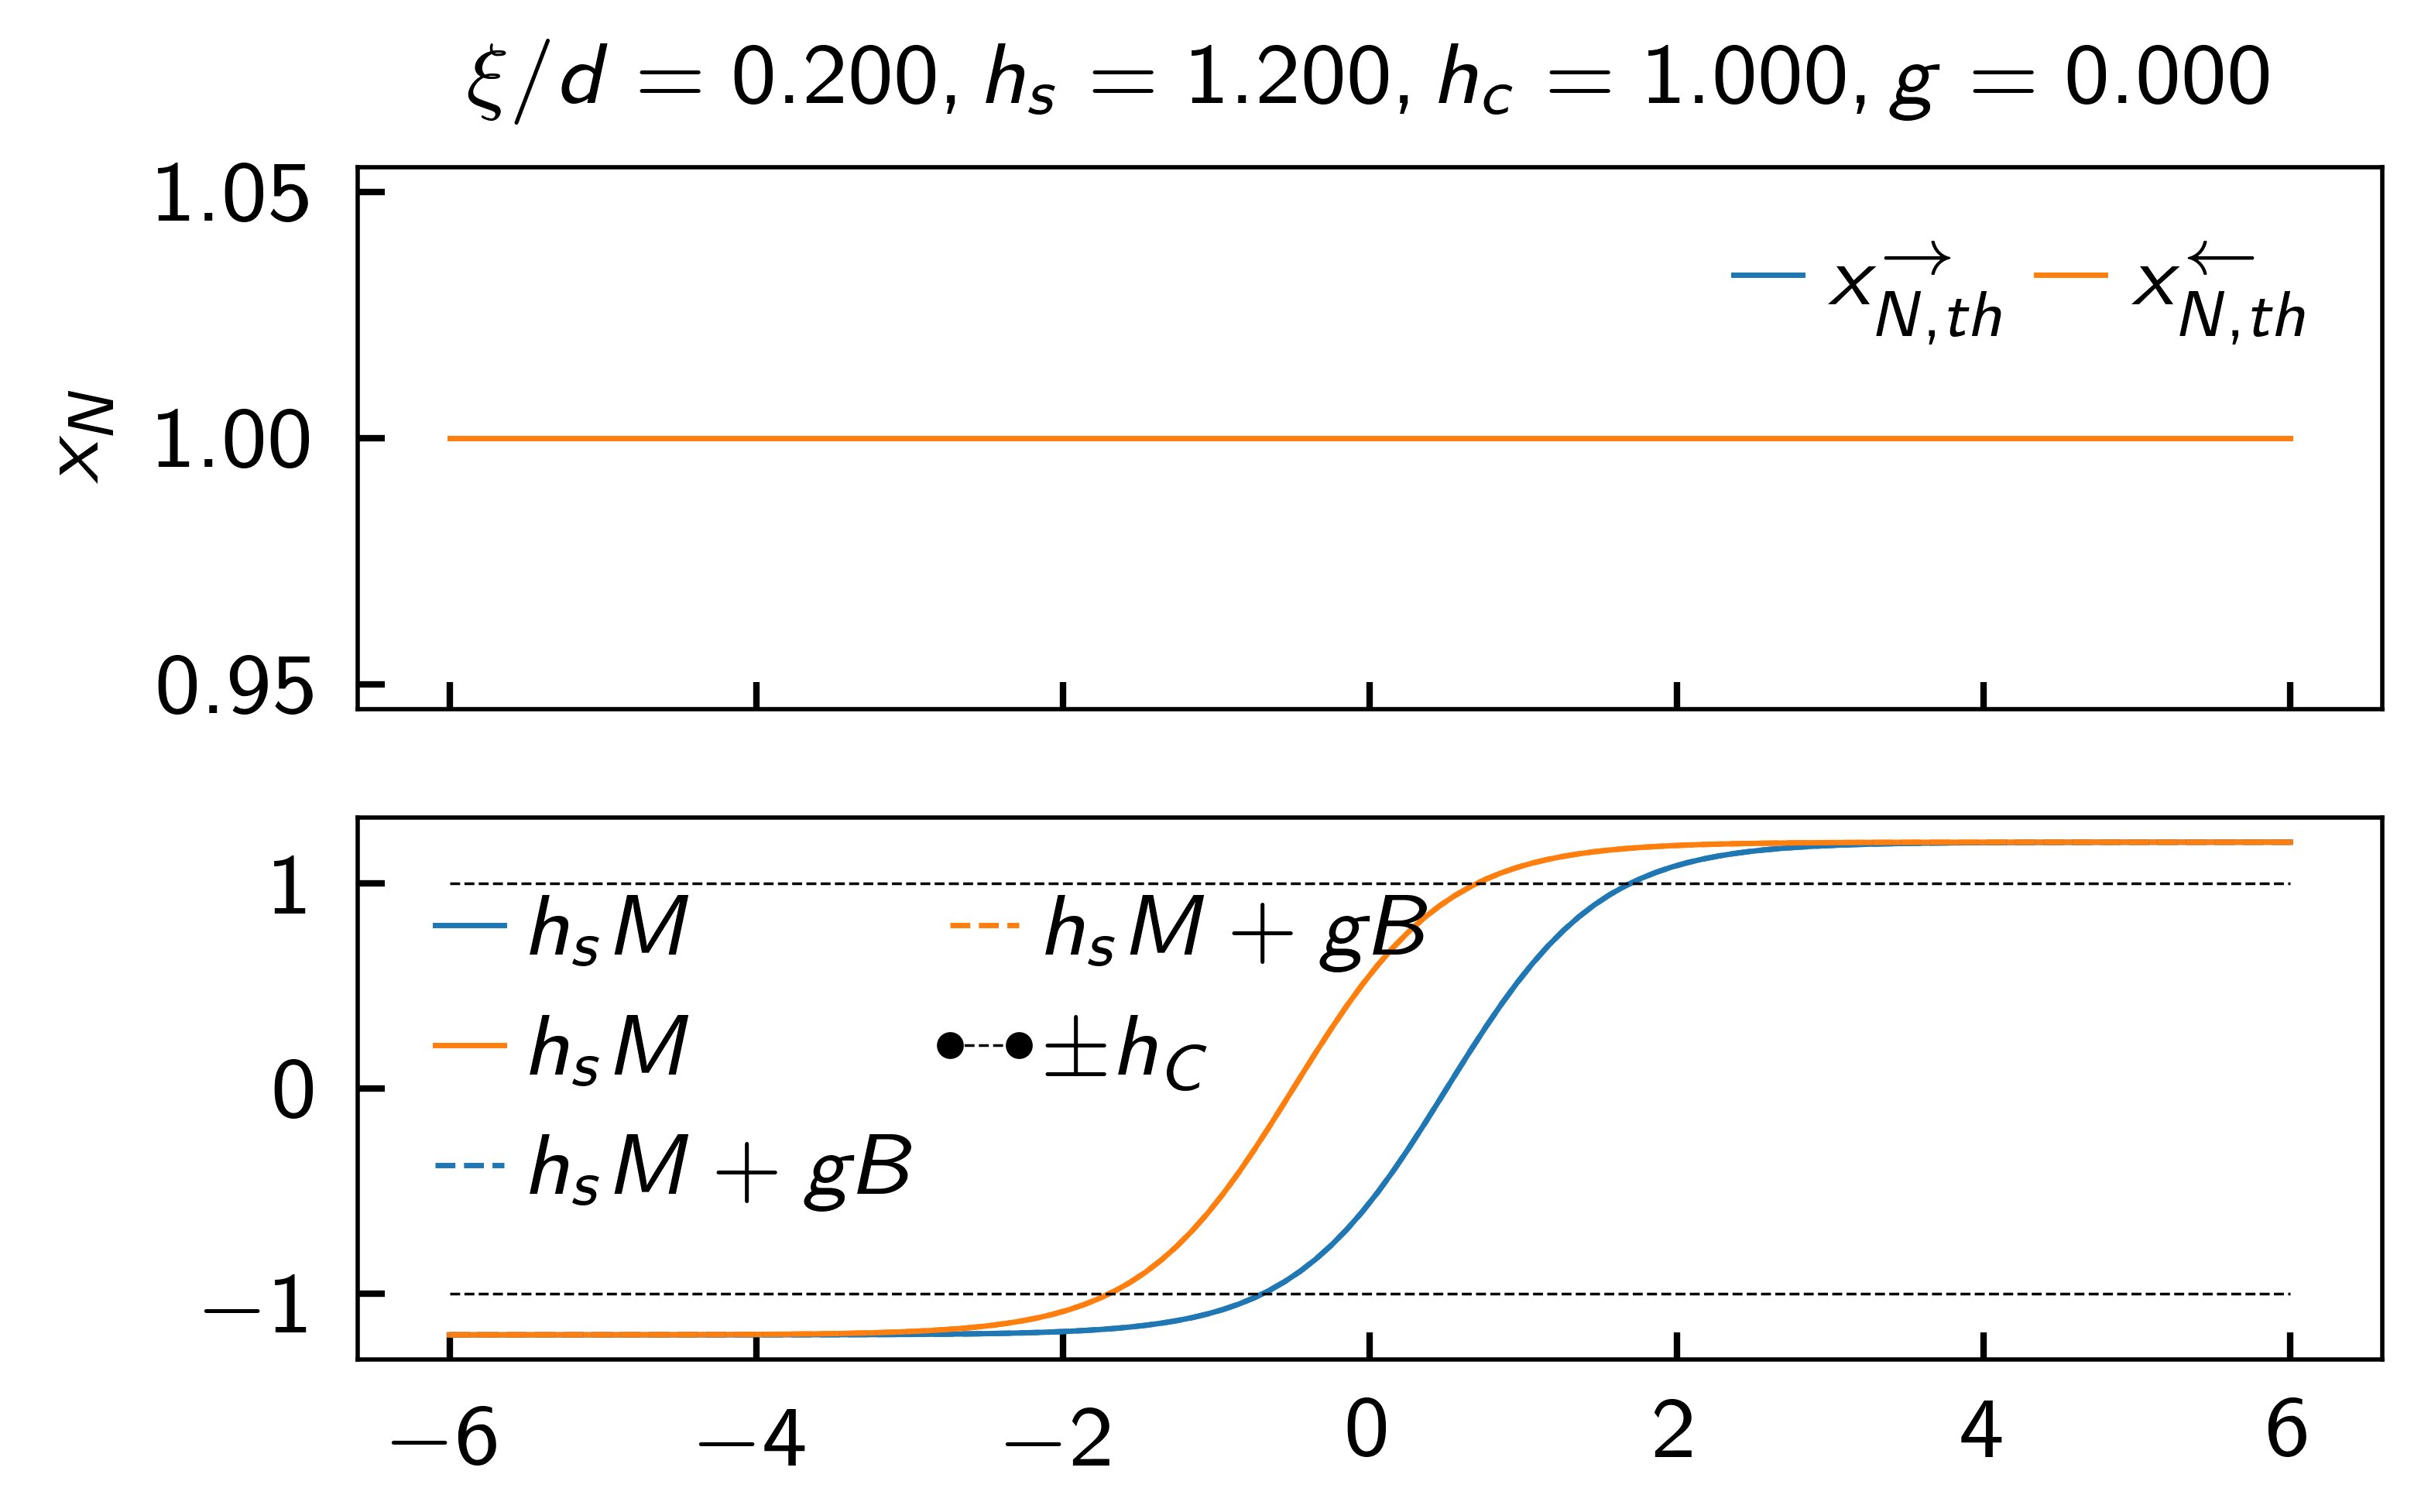

In [7]:
plot_NIS(h_c=1, h_s=1.2, xi=0.2, g=0.0)

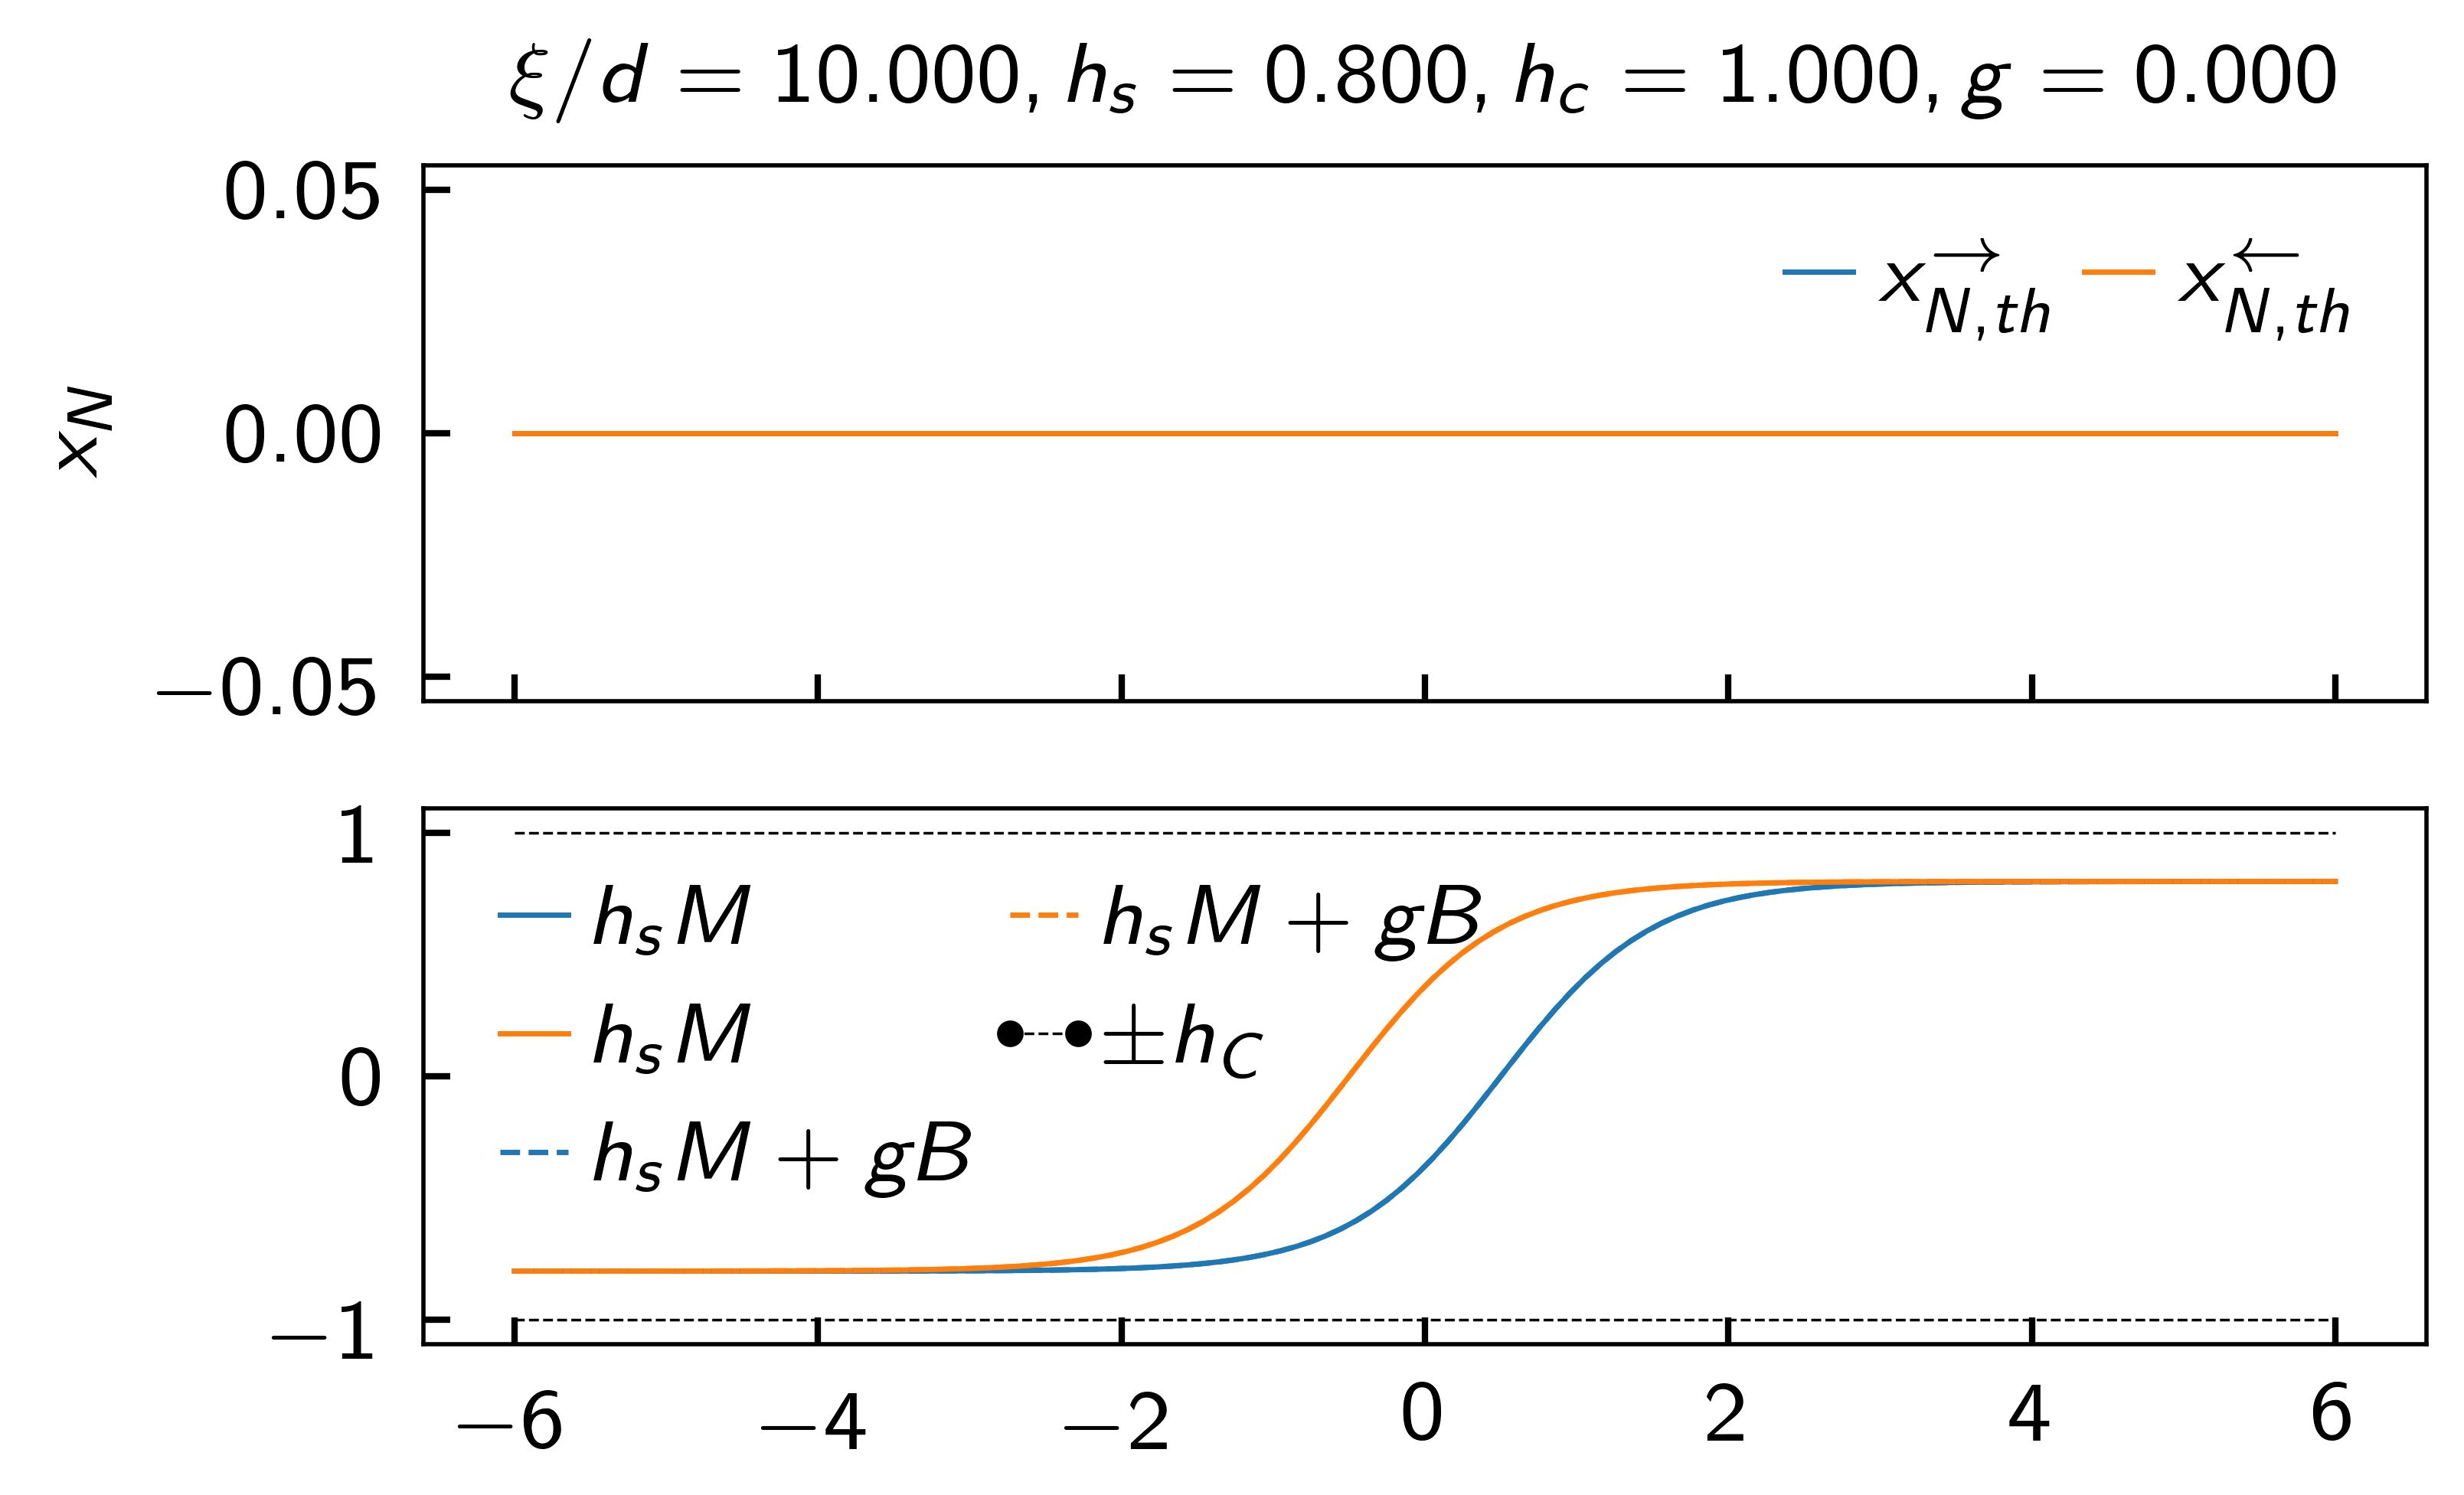

In [8]:
plot_NIS(h_c=1, h_s=0.8, xi=10, g=0.0)

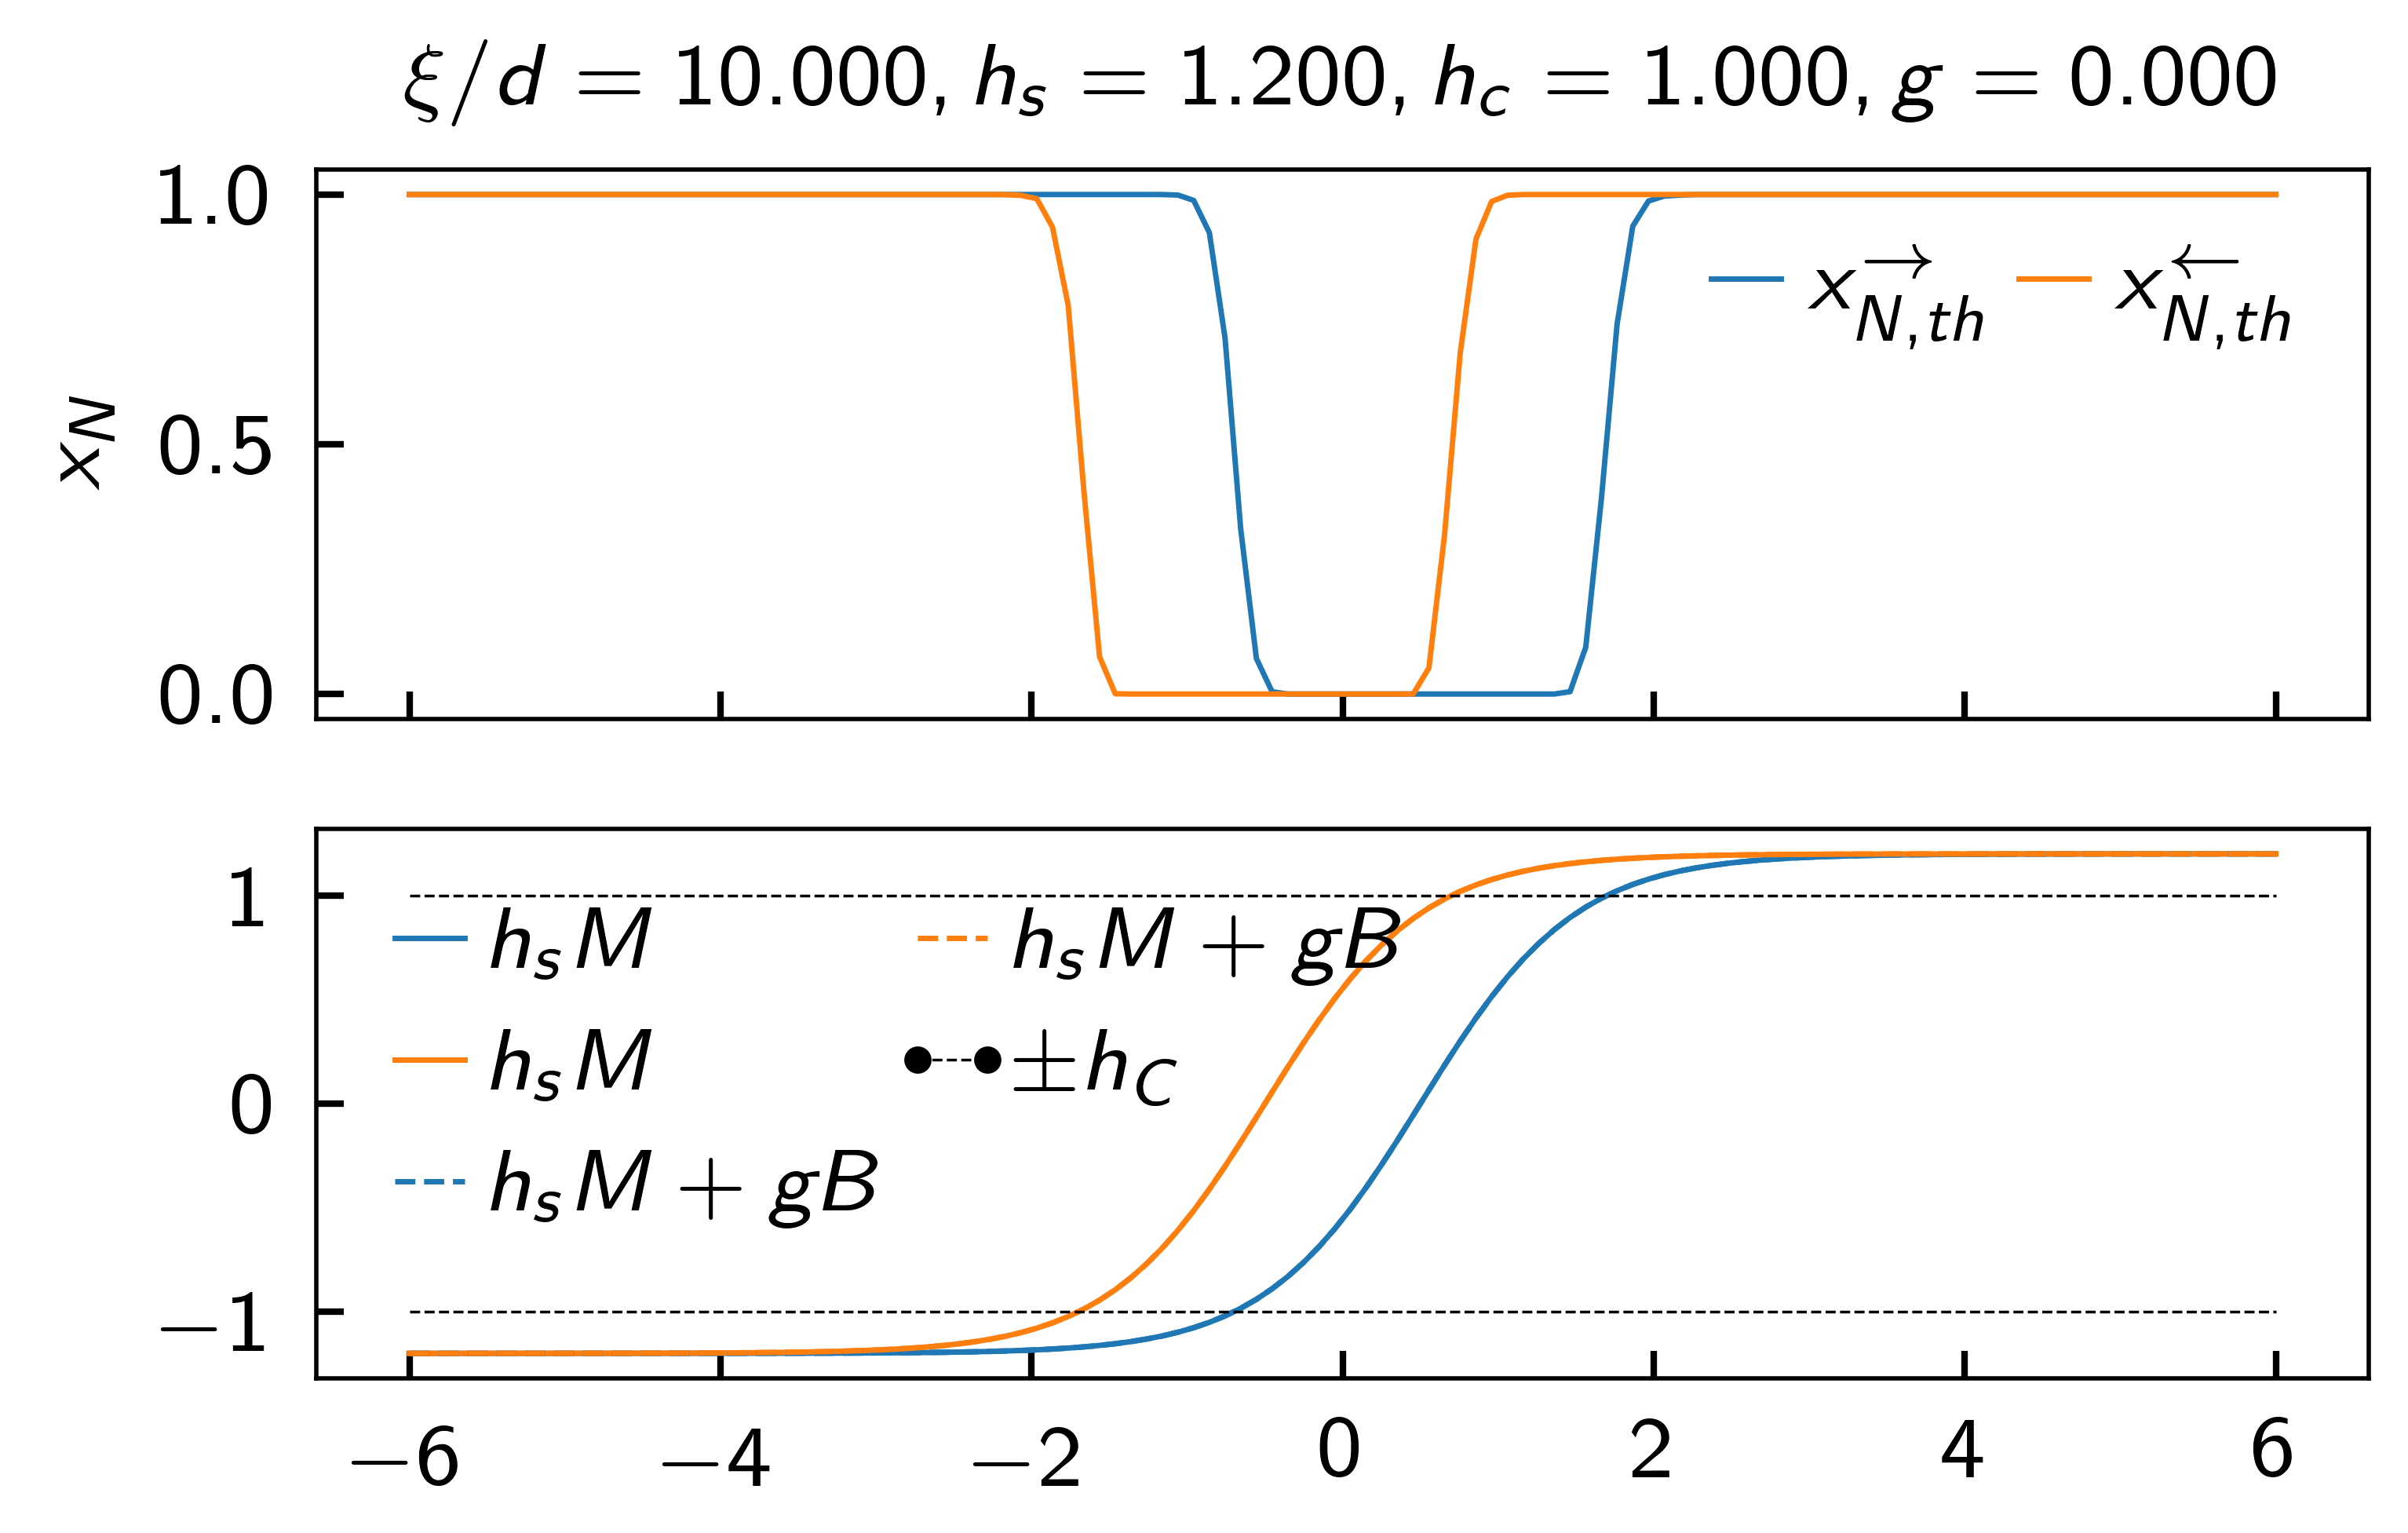

In [9]:
plot_NIS(h_c=1, h_s=1.2, xi=10, g=0.0)

# With Zeeman

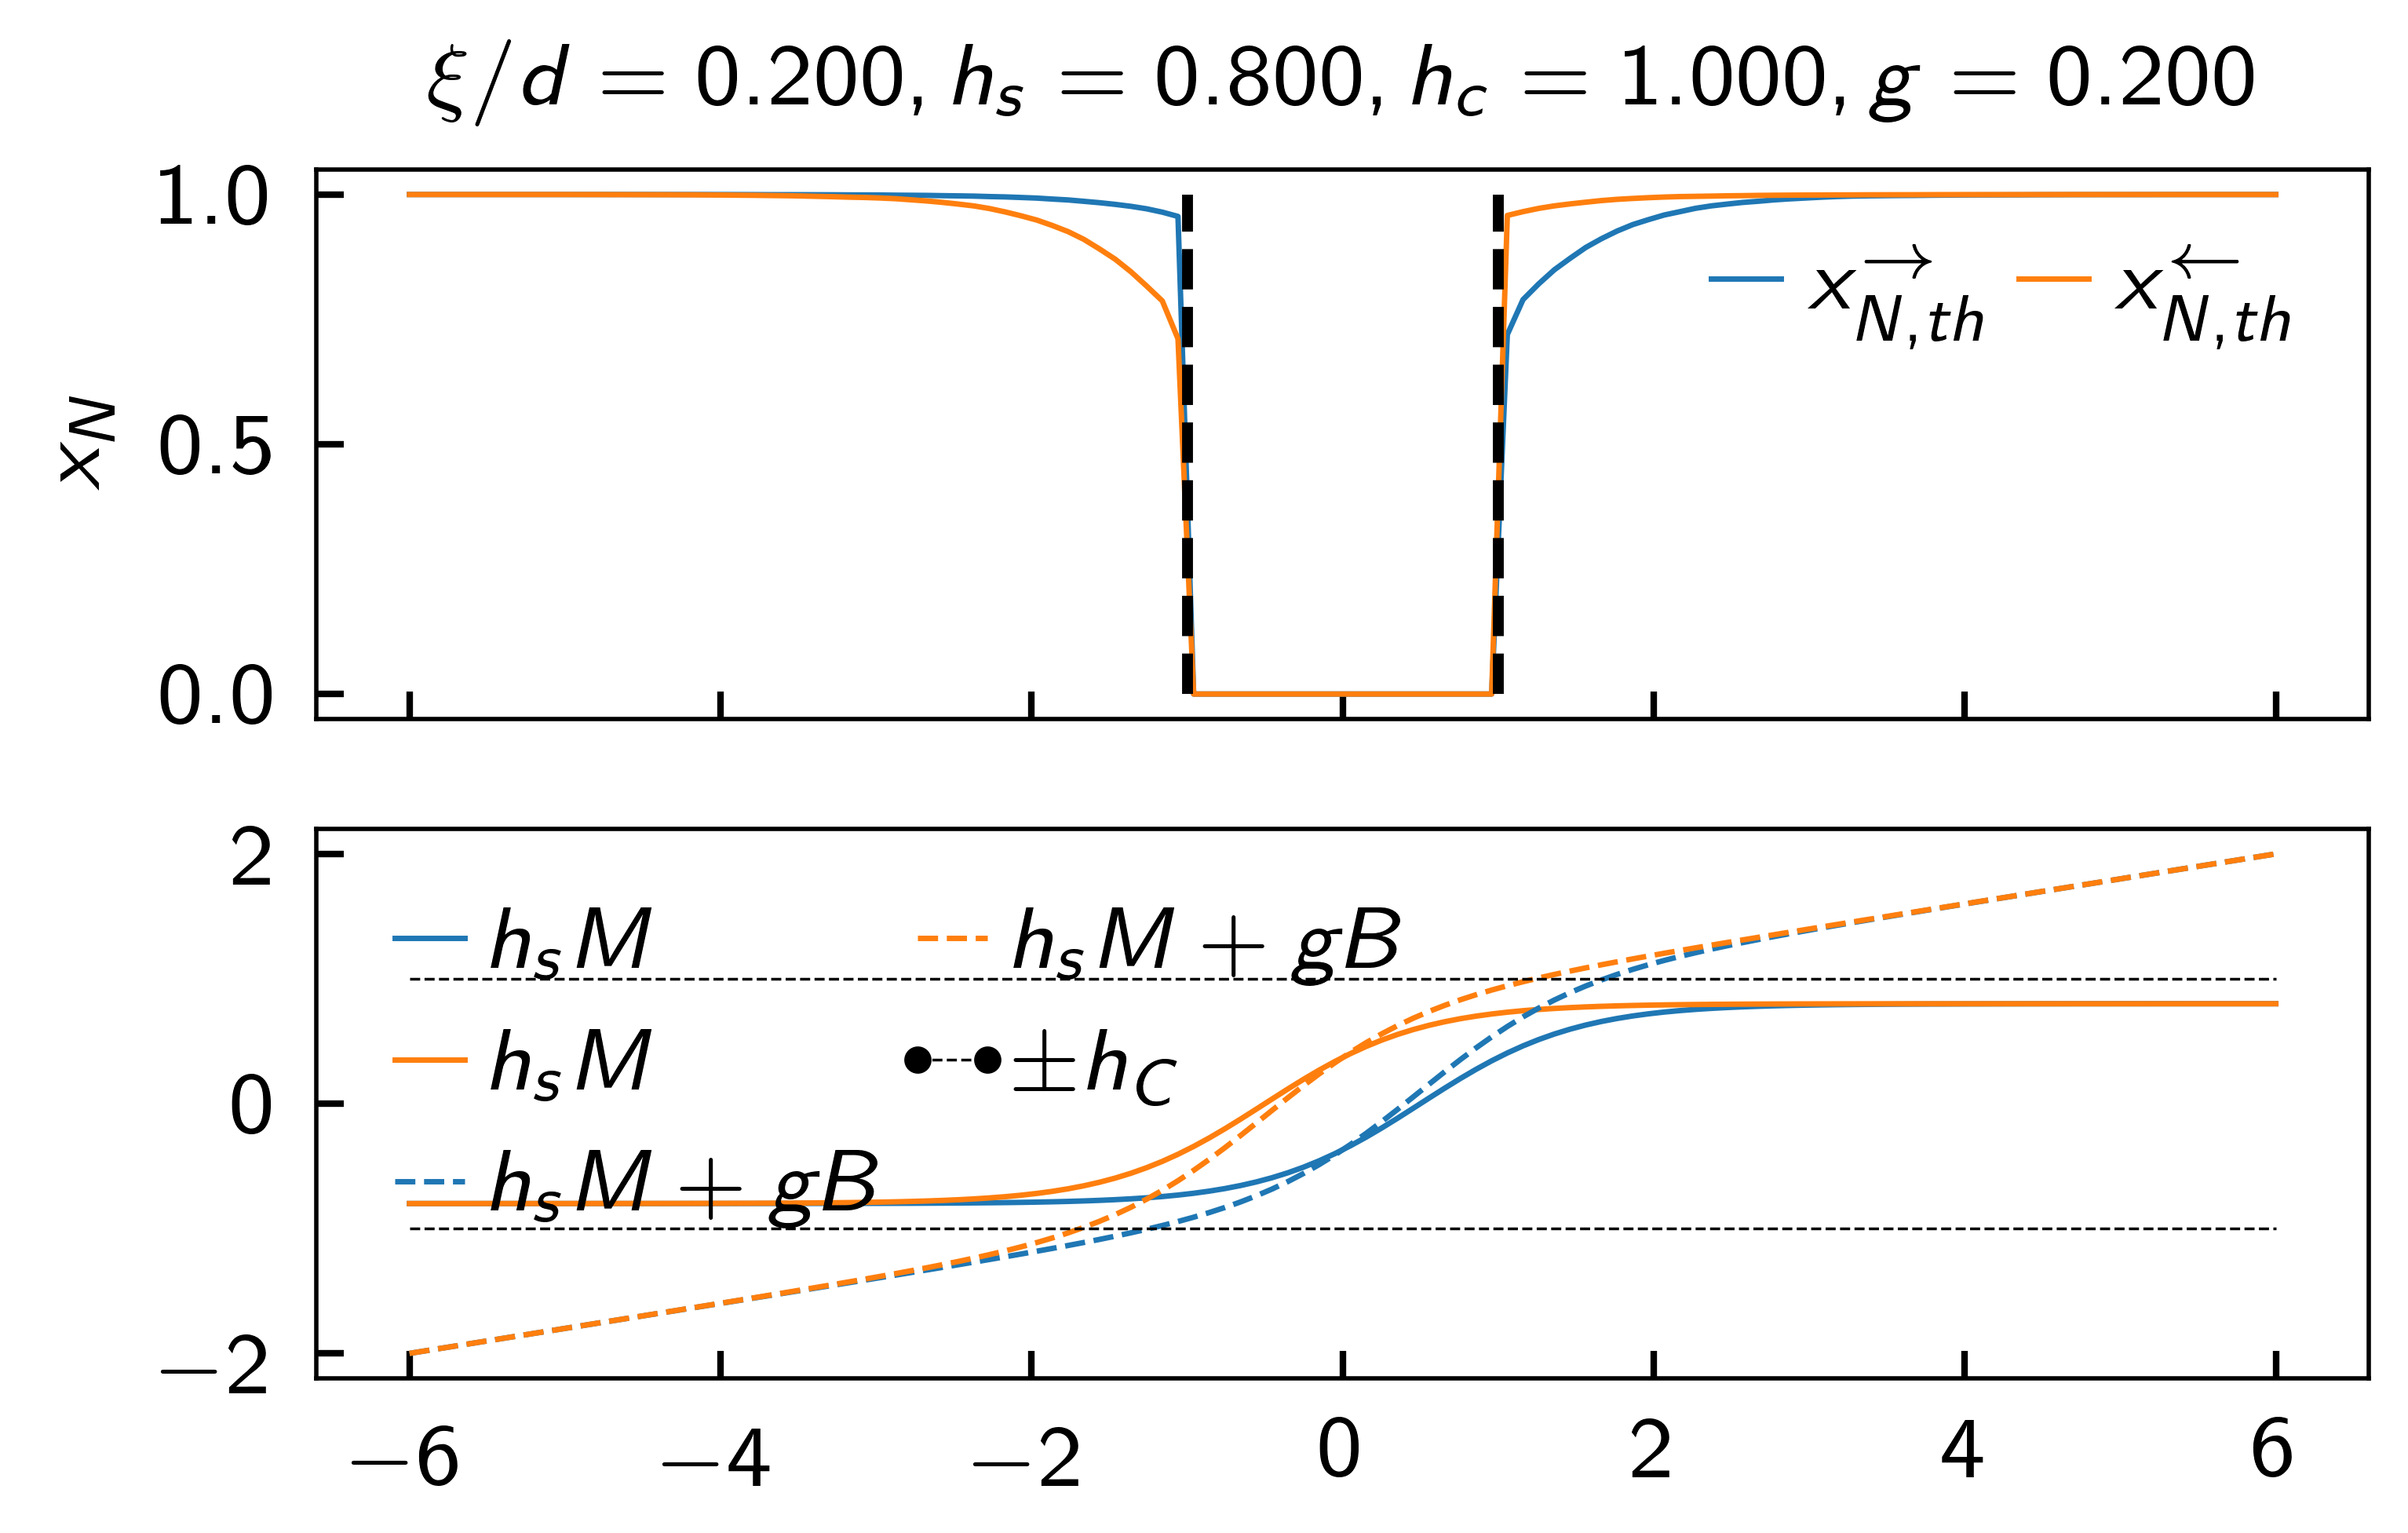

In [10]:
plot_NIS(h_c=1, h_s=0.8, xi=0.2, g=0.2)

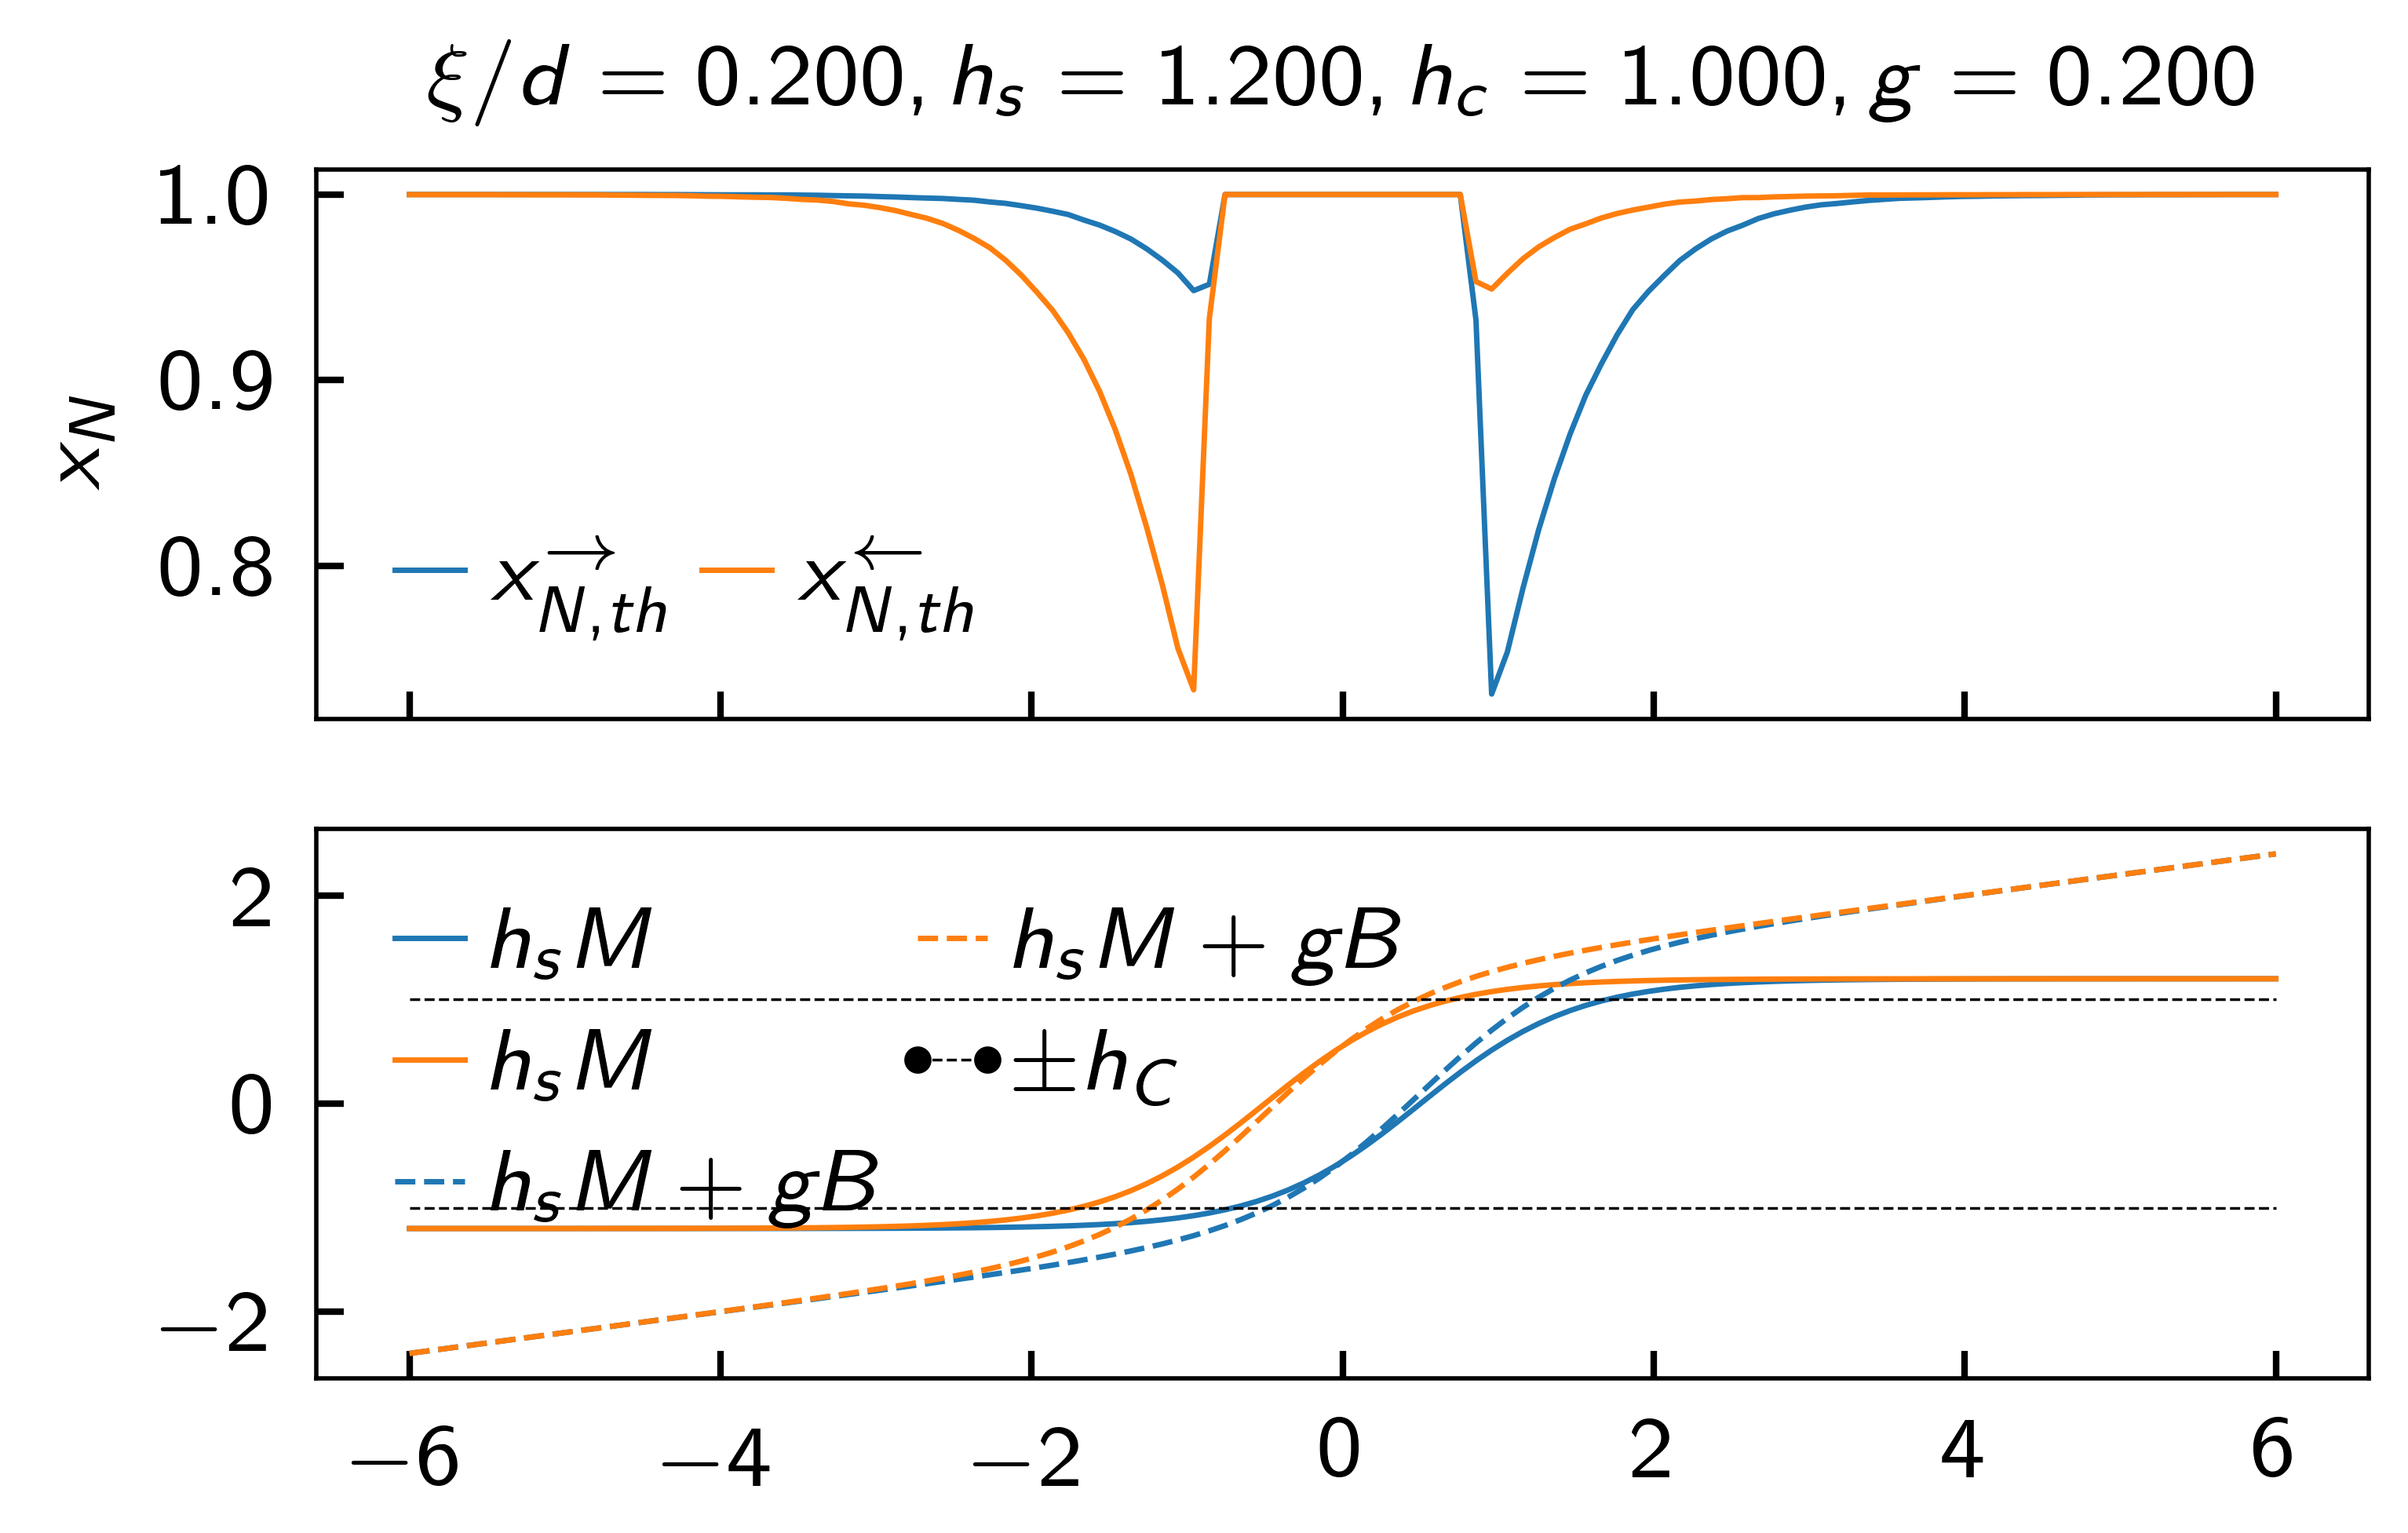

In [11]:
plot_NIS(h_c=1, h_s=1.2, xi=0.2, g=0.2)

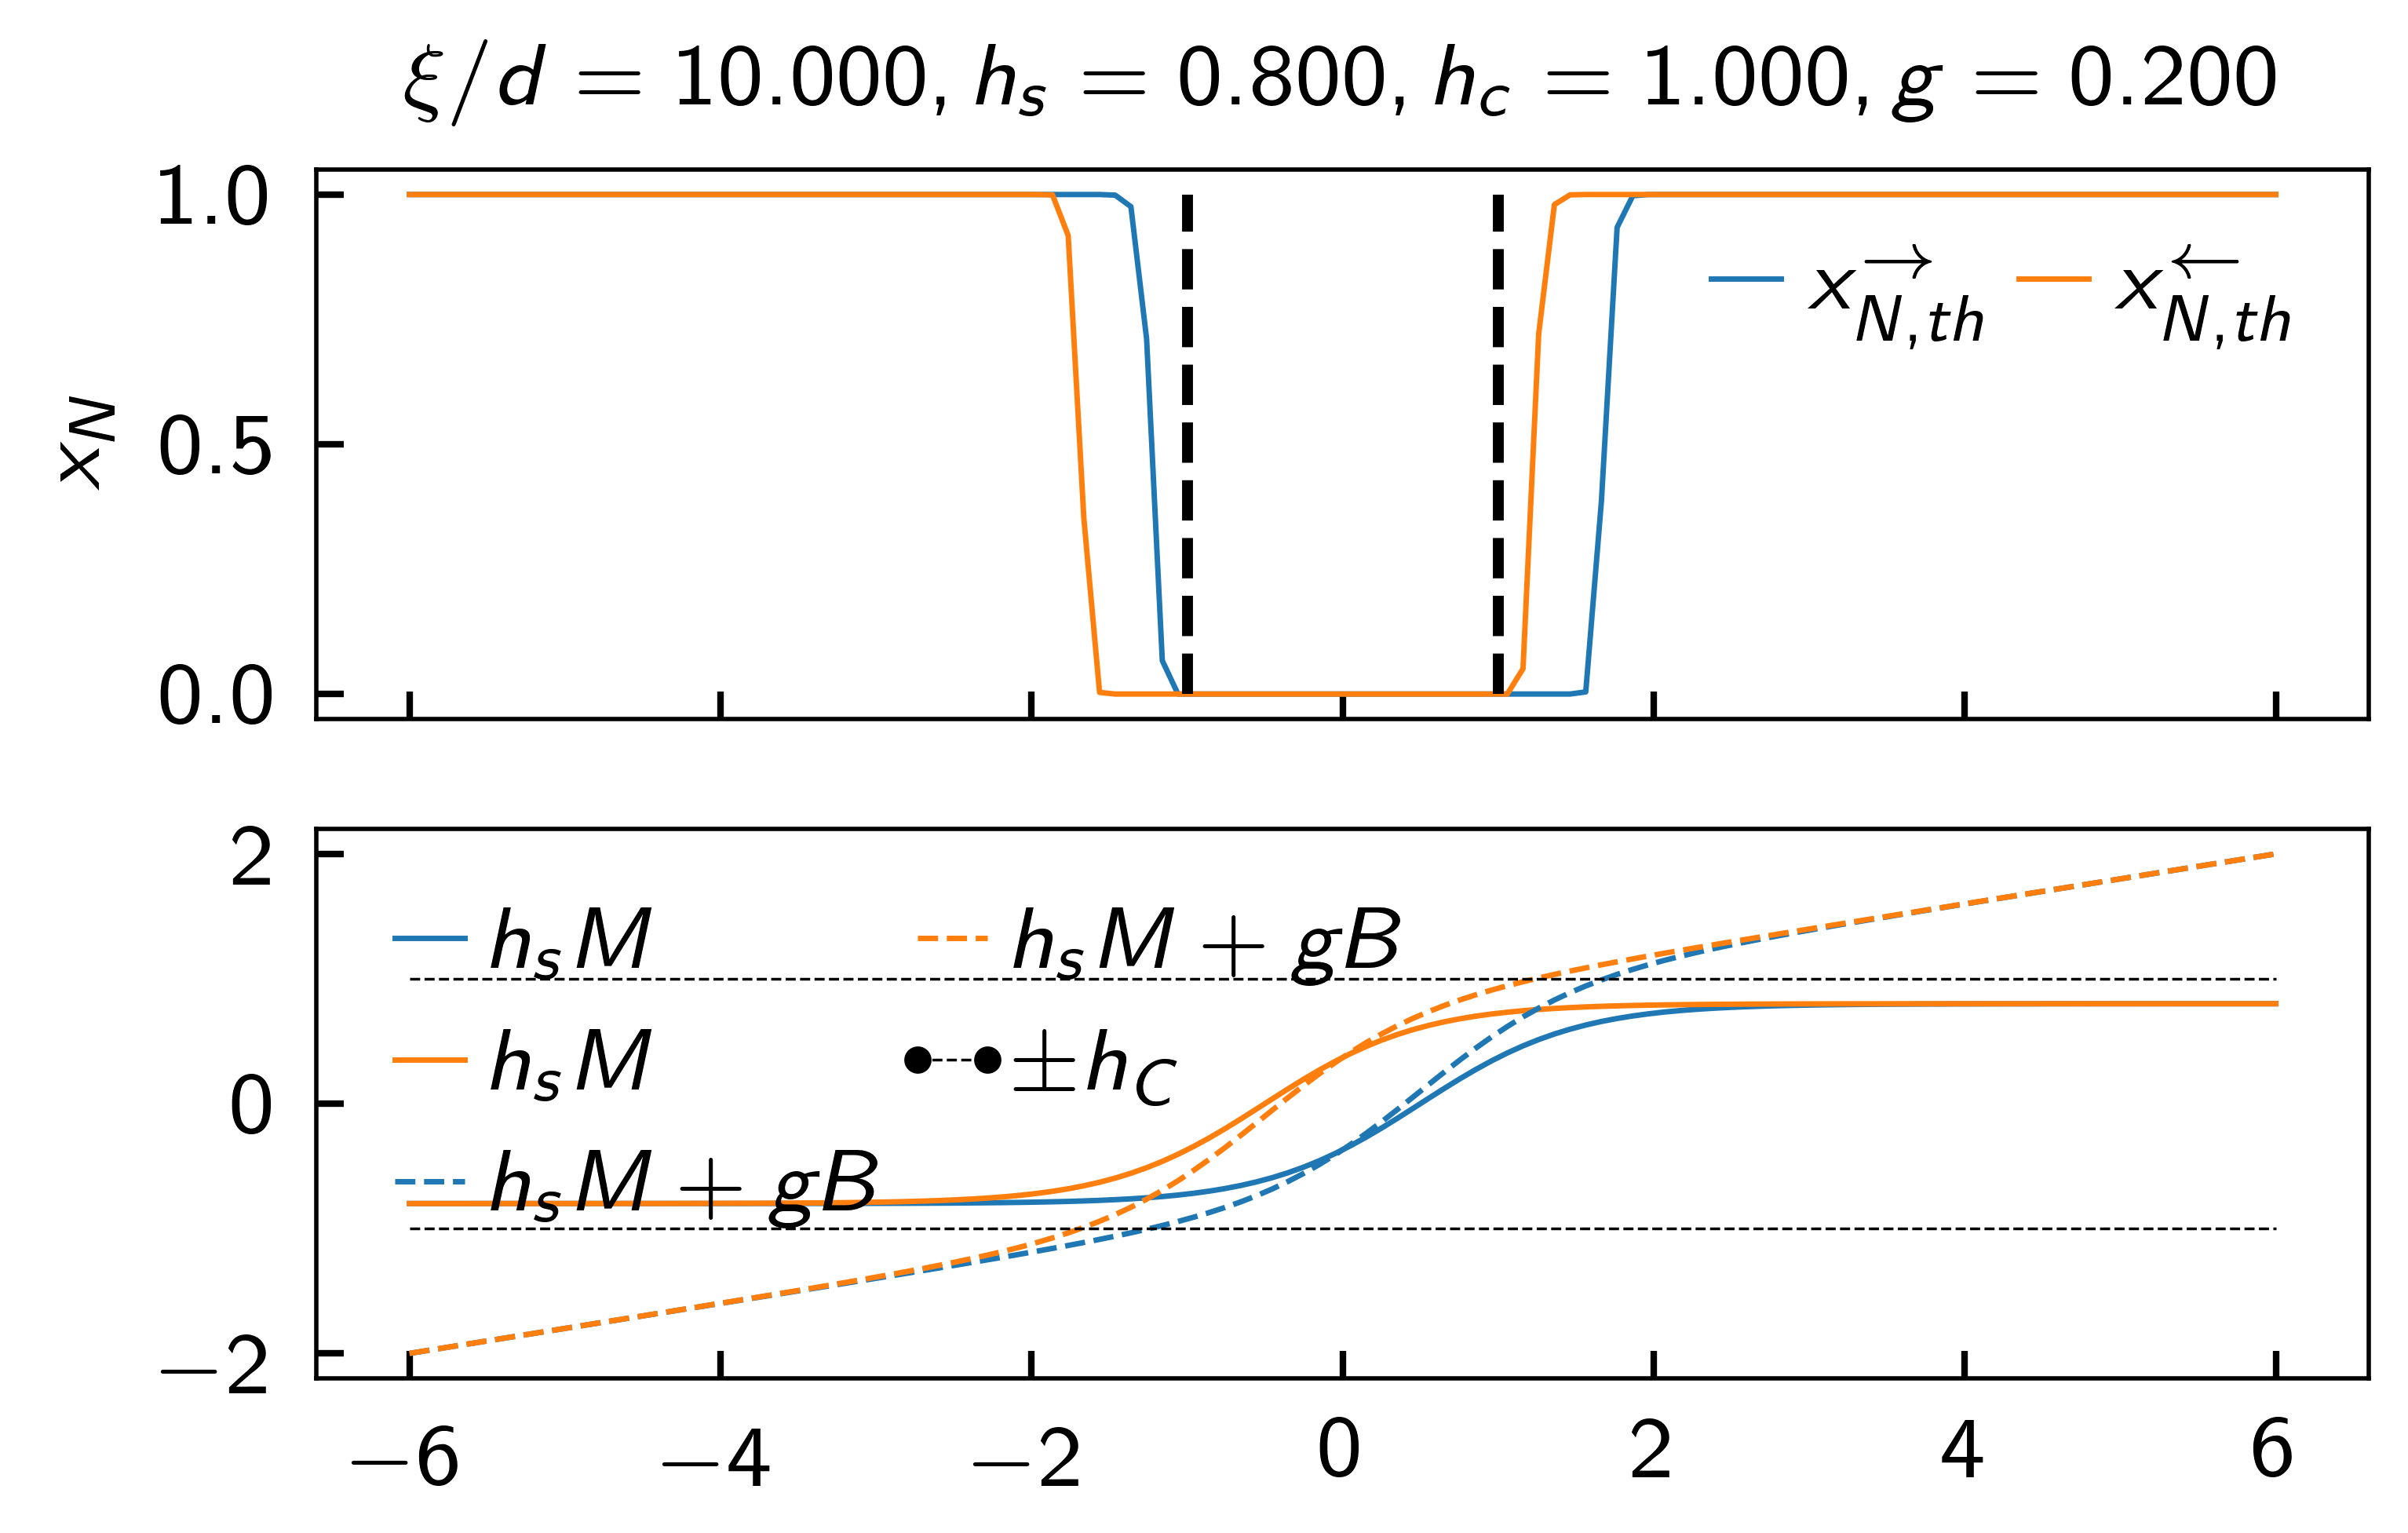

In [12]:
plot_NIS(h_c=1, h_s=0.8, xi=10, g=0.2)

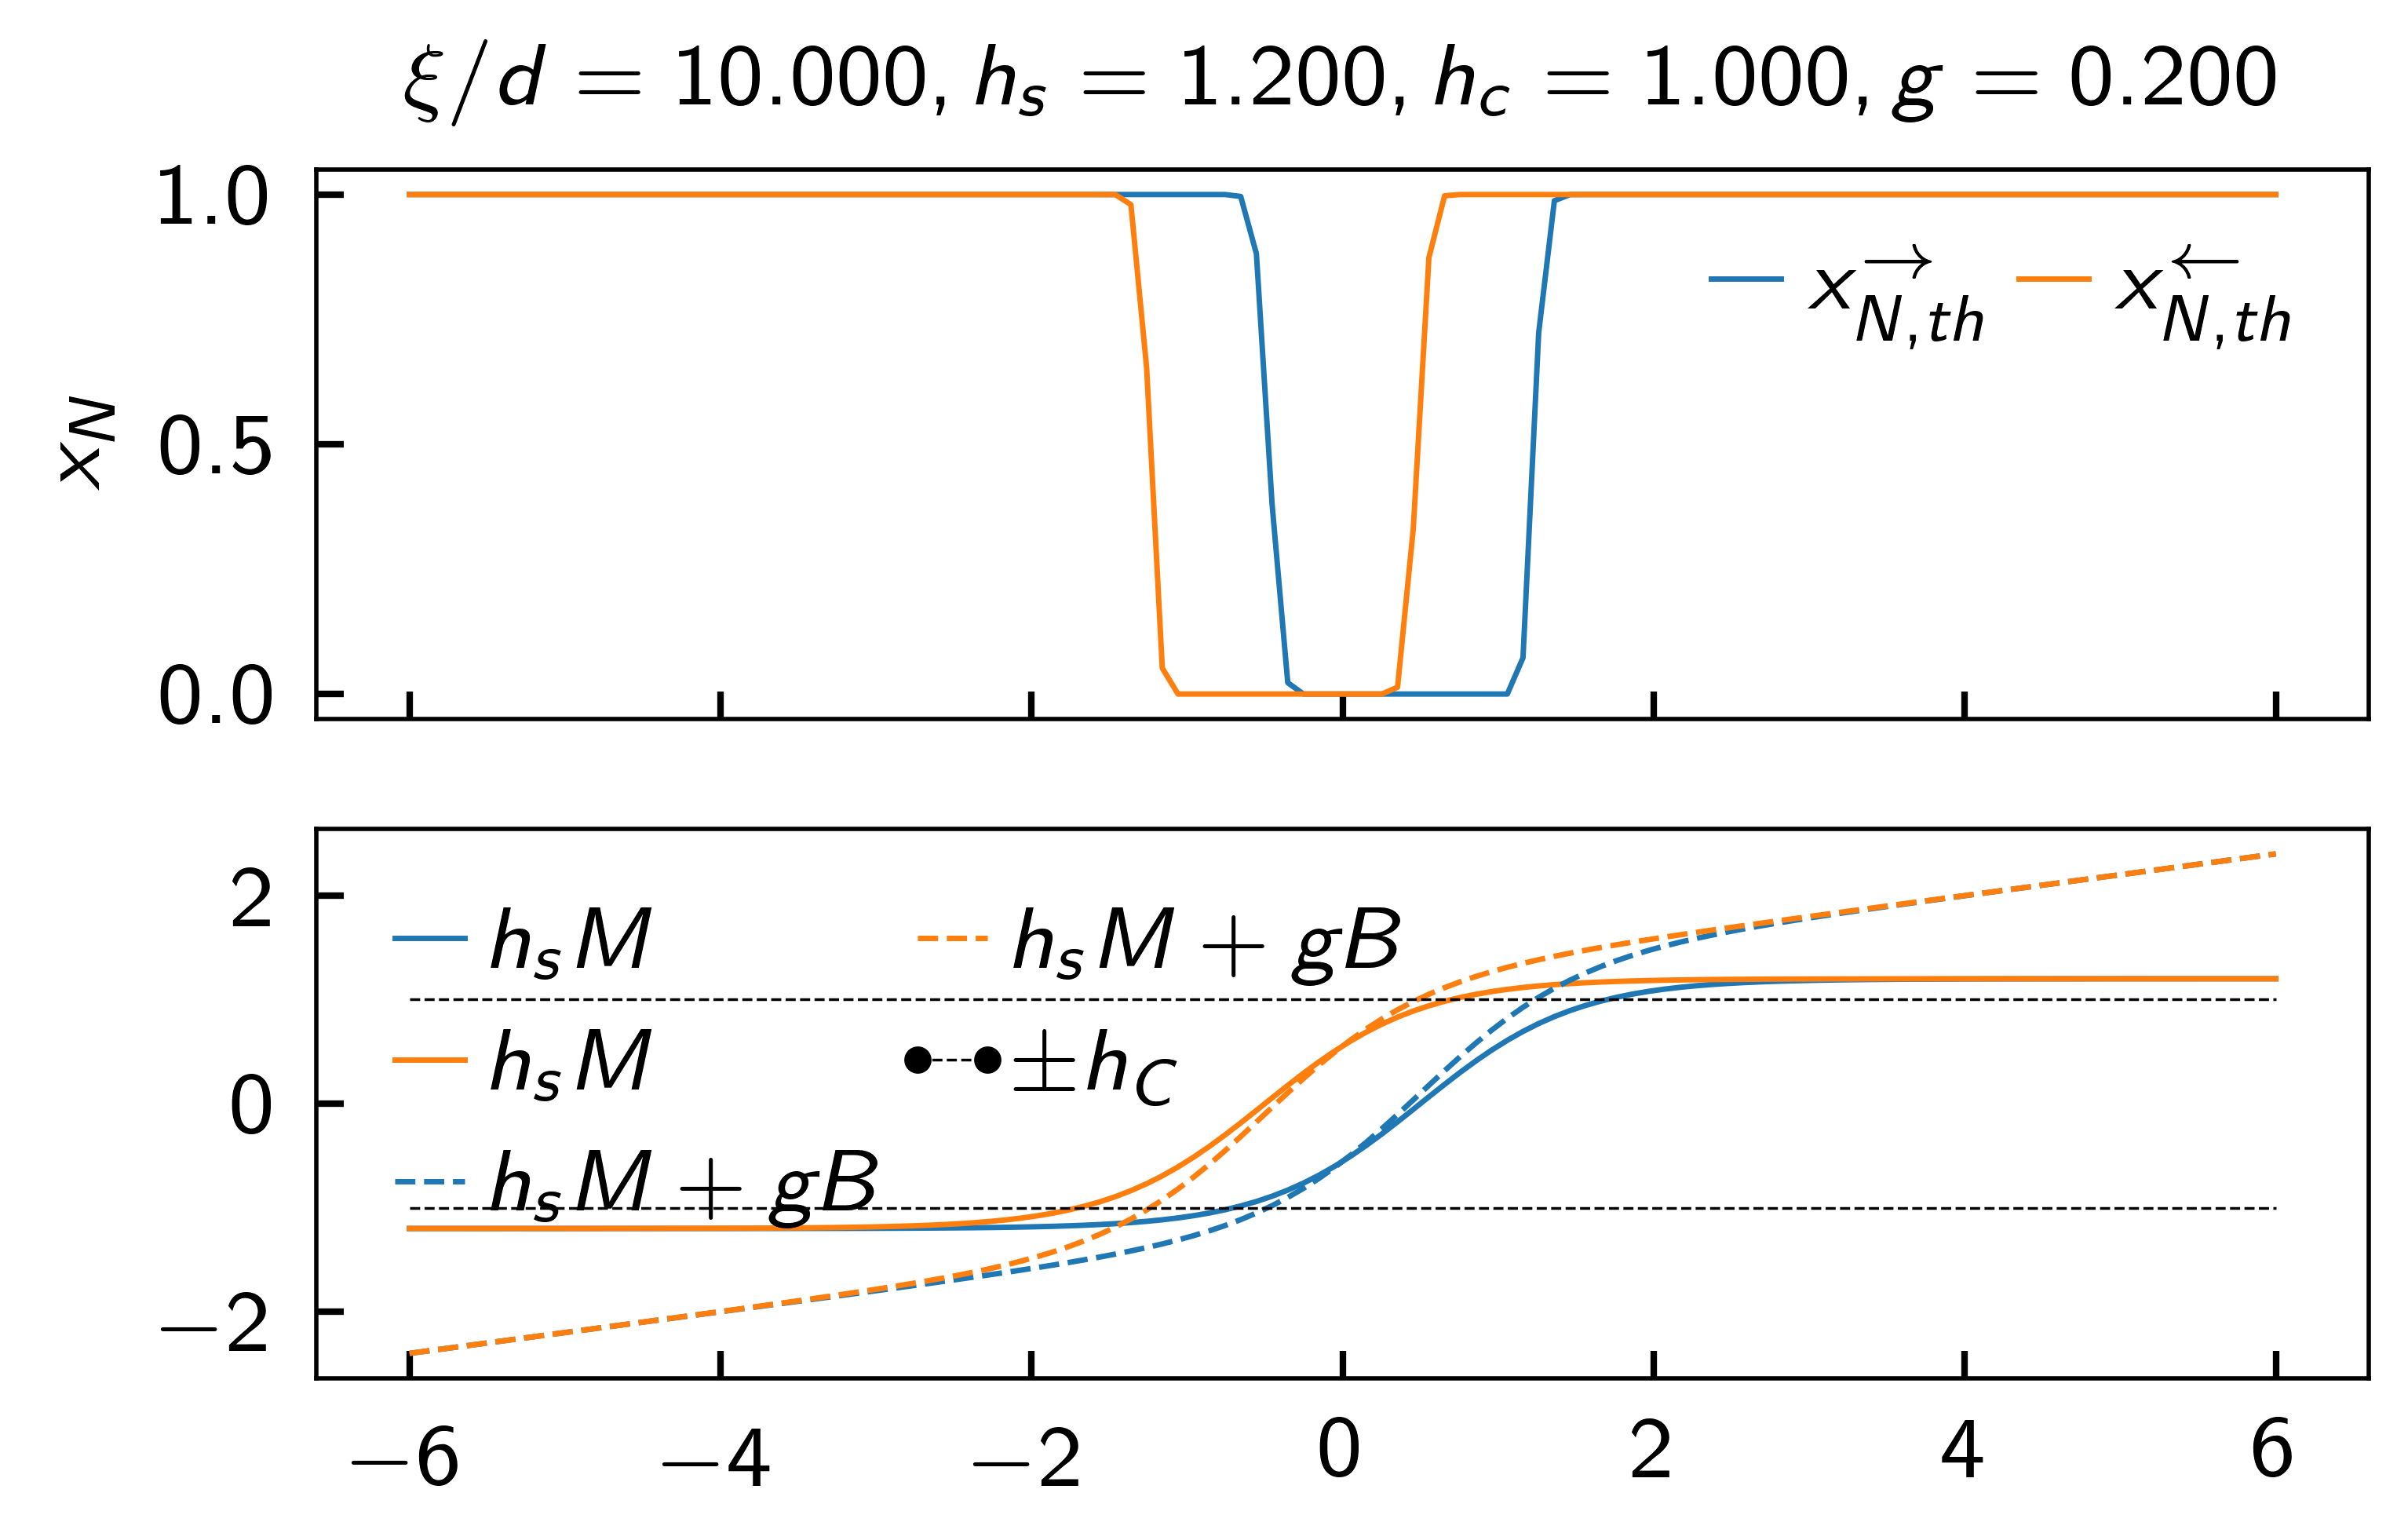

In [13]:
plot_NIS(h_c=1, h_s=1.2, xi=10, g=0.2)